In [ ]:
#Mount the drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Exploration Data Analysis (EDA)



Load and clean the dataset

In [3]:
#unzip the dataset
!unzip "/content/dataset_hmw2.zip" -d "/content"

Archive:  /content/dataset_hmw2.zip
   creating: /content/dataset_hmw2/
  inflating: /content/__MACOSX/._dataset_hmw2  
  inflating: /content/dataset_hmw2/y_train.npy  
  inflating: /content/__MACOSX/dataset_hmw2/._y_train.npy  
  inflating: /content/dataset_hmw2/x_train.npy  
  inflating: /content/__MACOSX/dataset_hmw2/._x_train.npy  


In [4]:
#load the targets
y_numpy = np.load("/content/dataset_hmw2/y_train.npy")
#check the shape
print(np.shape(y_numpy))
print(y_numpy)

(2429,)
[ 0  0  0 ... 11 11 11]


In [5]:
#load the dataset
x_numpy = np.load("/content/dataset_hmw2/x_train.npy")
#check the shape
print(np.shape(x_numpy))
print(x_numpy[0])

(2429, 36, 6)
[[ 1.7597e+01  8.1713e+00 -1.7842e+00 -1.9706e+01 -9.7135e+00 -6.1887e+01]
 [ 2.2974e-01 -5.8956e+00  1.6837e+01  5.0390e+00  2.4332e+00  5.8914e+01]
 [-2.9654e+01 -2.1296e+01  2.9103e+01 -4.7503e-01  7.5391e+01  1.0665e+01]
 [-5.9210e+01 -2.9565e+01  1.7971e+01 -4.5606e+01  1.9412e+01 -4.3014e+01]
 [-7.2064e+01 -2.5855e+01  4.6536e-01 -5.9151e+01 -2.9105e+01 -1.1913e+01]
 [-5.8355e+01 -1.2052e+01 -3.7655e+00 -1.5372e+01  4.3188e+01  1.3452e+01]
 [-2.4086e+01  4.3008e+00  1.3528e+00  1.8384e+01  1.7627e+01 -6.4709e+01]
 [ 9.5313e+00  1.4598e+01  3.4580e+00  1.6364e+00 -2.7640e+00 -3.8644e+01]
 [ 1.9020e+01  1.4387e+01 -2.0542e+00 -1.9377e+01  3.0842e+01  1.2618e+02]
 [-3.3500e+00  6.0219e+00 -1.0826e+01 -1.1767e+00  9.8274e+00  2.6656e+00]
 [-4.0648e+01 -2.9042e+00 -1.3918e+01  3.5964e+01  1.9826e+01  2.6247e+01]
 [-6.1347e+01 -4.5803e+00 -8.3675e+00  5.2520e+01 -2.9621e+01  2.3897e+01]
 [-4.3567e+01  3.4607e+00 -8.4096e-01  3.6865e+01 -5.1364e+00  2.3074e+01]
 [ 4.9636e+

#### Prova

In [6]:
#Standardization on every 'feature'
scaler = StandardScaler()
X = scaler.fit_transform(x_numpy.reshape(-1,x_numpy.shape[-1])).reshape(x_numpy.shape)

In [7]:
#import pickle to save the scaler and to then transport it in the zip to apply standardization in the model.py
import pickle 

with open('scaler.pickle', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [8]:
with open('scaler.pickle', 'rb') as handle:
    b = pickle.load(handle)


### Inspect dataset

In [14]:
#create copies in order to plot the time series
xplot= X.copy()
yplot = y_numpy.copy()
xplot.shape, yplot.shape

((2429, 36, 6), (2429,))

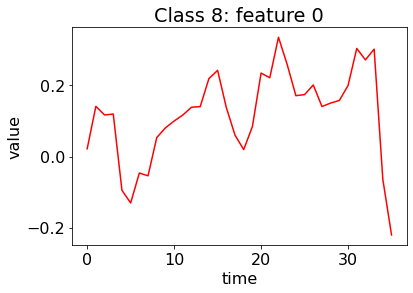

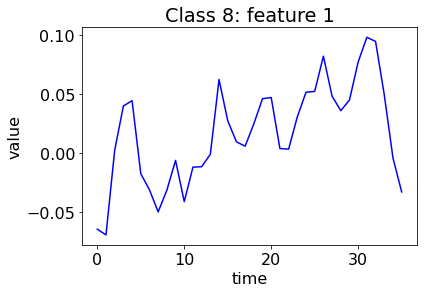

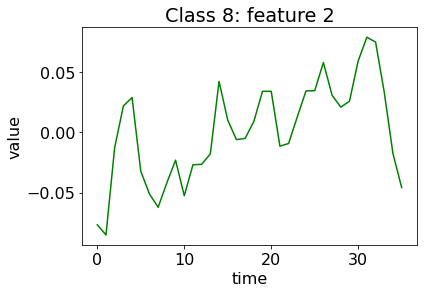

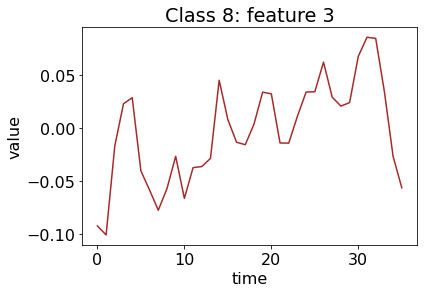

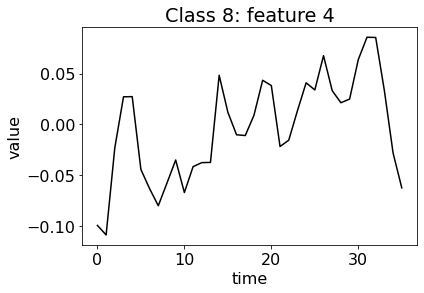

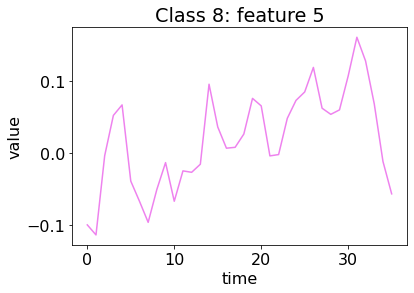

In [23]:
#choose and index between 0 and 2429
index = 1500
#to get the corresponding class
classe = str(yplot[index])
#some colors to distinguish the features
colori = ['red', 'blue', 'green', 'brown', 'black', 'violet']
#print 6 graphs
for i in range(6):
  feature = str(i)
  plt.title("Class " + classe + ': feature ' + feature)
  plt.xlabel("time")
  plt.ylabel("value")
  time= np.arange(0,36)
  plt.plot(time, xplot[index,:,i], color = colori[i])
  plt.show()

### Preprocessing v2

In [9]:
#split datset in train and validation set
X_train, X_val , y_train , y_val = train_test_split(X, y_numpy, test_size= 0.2)

#check shape
X_train.shape , y_train.shape, X_val.shape , y_val.shape

((1943, 36, 6), (1943,), (486, 36, 6), (486,))

In [10]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

X_train.shape , y_train.shape, X_val.shape , y_val.shape

((1943, 36, 6), (1943, 12), (486, 36, 6), (486, 12))

### Build and train models

In [ ]:
#parameters to train the models, epochs and batch_size may vary
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 32
epochs = 200
print(input_shape)
print(classes)

(36, 6)
12


#### 1D Convolutional Neural Network (best so far)

![](https://drive.google.com/uc?export=view&id=10B7c-F58-eNr6CP7D_UZeVp0gTeYMrFQ
)

In [ ]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(64,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(64,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(64, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
#build the model and print structure
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 64)            1216      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 64)            12352     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 64)                0     

In [ ]:
# I Trained the model for exaclty 337 epochs
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 337,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=100, restore_best_weights=True)
    ]
).history

Epoch 1/337
61/61 [==============================] - 10s 16ms/step - loss: 2.3311 - accuracy: 0.3263 - val_loss: 2.0894 - val_accuracy: 0.3436
Epoch 2/337
61/61 [==============================] - 1s 8ms/step - loss: 2.0093 - accuracy: 0.3531 - val_loss: 1.9249 - val_accuracy: 0.3621
Epoch 3/337
61/61 [==============================] - 1s 10ms/step - loss: 1.9432 - accuracy: 0.3726 - val_loss: 1.8717 - val_accuracy: 0.3724
Epoch 4/337
61/61 [==============================] - 0s 8ms/step - loss: 1.8895 - accuracy: 0.3814 - val_loss: 1.8392 - val_accuracy: 0.3683
Epoch 5/337
61/61 [==============================] - 0s 8ms/step - loss: 1.8590 - accuracy: 0.3891 - val_loss: 1.7927 - val_accuracy: 0.3930
Epoch 6/337
61/61 [==============================] - 0s 7ms/step - loss: 1.8312 - accuracy: 0.3963 - val_loss: 1.7484 - val_accuracy: 0.3971
Epoch 7/337
61/61 [==============================] - 1s 8ms/step - loss: 1.8075 - accuracy: 0.4014 - val_loss: 1.7481 - val_accuracy: 0.3971
Epoch 8/33

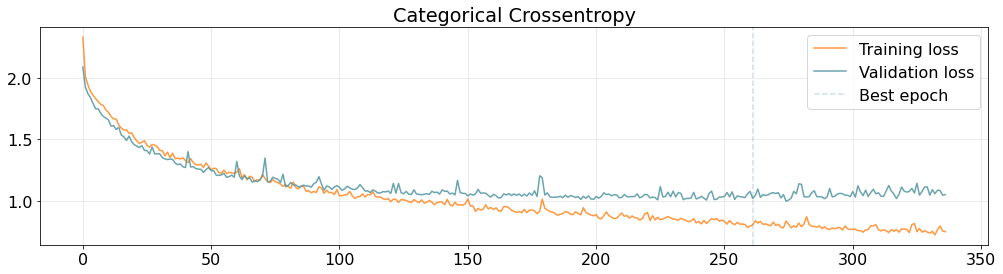

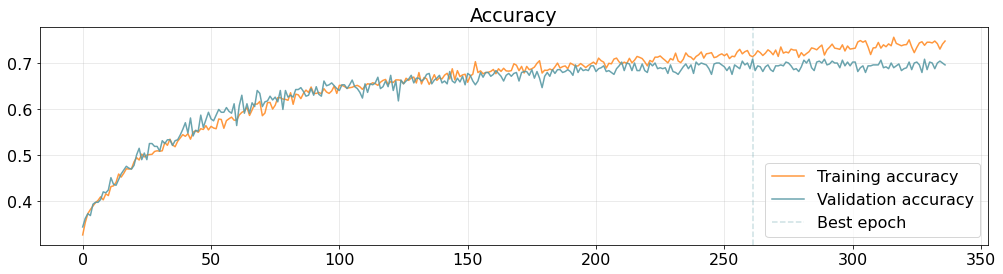

In [ ]:
#Plot the results
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()



## Salva

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/drive


In [ ]:
model.save('/content/gdrive/MyDrive/HMWFINALTRY/1DCNN')


In [ ]:
model_1 = model
model_1.save('/content/1DCNN')

## LSTM + CONV1d

In [ ]:
def build_1DCNN_Lstm_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(64,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(64,3,padding='same',activation='relu')(cnn)
    lstm= tfkl.LSTM(64)(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)



    # Classifier
    classifier = tfkl.Dense(64, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
#build the model and print structure
model = build_1DCNN_Lstm_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 36, 64)            1216      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 64)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 18, 64)            12352     
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                             

In [ ]:
#Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 300,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25, restore_best_weights=True)
    ]
).history

Epoch 1/300
61/61 [==============================] - 4s 20ms/step - loss: 2.2237 - accuracy: 0.3206 - val_loss: 1.9681 - val_accuracy: 0.3498
Epoch 2/300
61/61 [==============================] - 1s 9ms/step - loss: 1.9320 - accuracy: 0.3685 - val_loss: 1.7705 - val_accuracy: 0.4095
Epoch 3/300
61/61 [==============================] - 1s 10ms/step - loss: 1.8242 - accuracy: 0.4092 - val_loss: 1.7002 - val_accuracy: 0.4218
Epoch 4/300
61/61 [==============================] - 1s 9ms/step - loss: 1.7506 - accuracy: 0.4251 - val_loss: 1.6706 - val_accuracy: 0.4156
Epoch 5/300
61/61 [==============================] - 1s 9ms/step - loss: 1.6823 - accuracy: 0.4318 - val_loss: 1.5454 - val_accuracy: 0.4630
Epoch 6/300
61/61 [==============================] - 0s 7ms/step - loss: 1.5872 - accuracy: 0.4632 - val_loss: 1.4691 - val_accuracy: 0.4938
Epoch 7/300
61/61 [==============================] - 0s 7ms/step - loss: 1.5010 - accuracy: 0.4874 - val_loss: 1.4177 - val_accuracy: 0.4979
Epoch 8/300

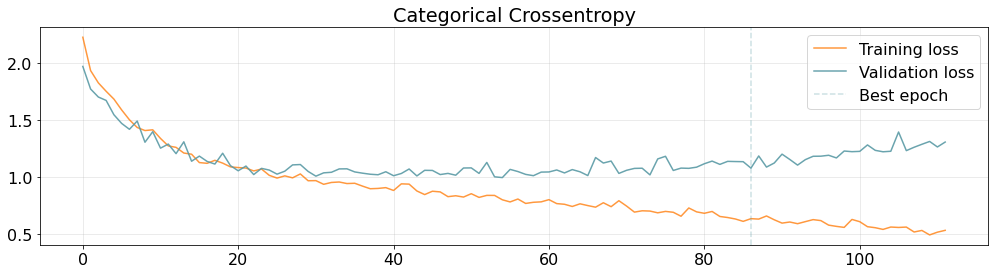

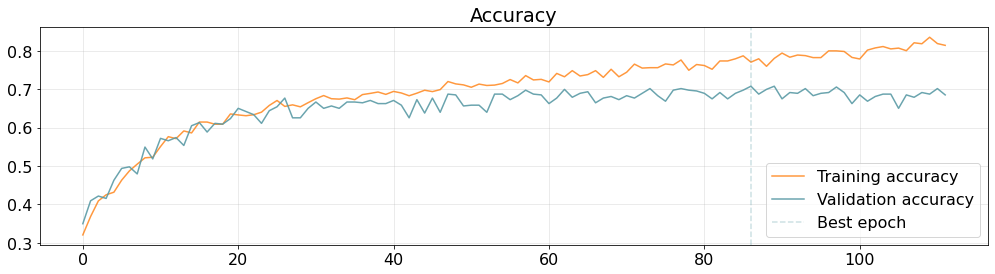

In [ ]:
#plot results
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()


## Salva

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/gdrive/MyDrive/HMW2FINALTRY/1DCLSTM')


In [ ]:
model_2= model 
model_2.save('/content/1DCLSTM')

## Resnet

In [ ]:
def Resnet_classifier(input_shape, classes):

  input_layer = tfkl.Input(shape=input_shape, name='Input')

  # BLOCK 1
  n_feature_maps = 18

  conv_x = tfkl.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
  conv_x = tfkl.Activation('relu')(conv_x)

  conv_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
  conv_y = tfkl.Activation('relu')(conv_y)

  conv_z = tfkl.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)

  # expand channels for the sum
  shortcut_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)

  output_block_1 = tfkl.add([shortcut_y, conv_z])
  output_block_1 = tfkl.Activation('relu')(output_block_1)

        # BLOCK 2

  conv_x = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
  conv_x = tfkl.Activation('relu')(conv_x)

  conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
  conv_y = tfkl.Activation('relu')(conv_y)

  conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)

  # expand channels for the sum
  shortcut_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)

  output_block_2 = tfkl.add([shortcut_y, conv_z])
  output_block_2 = tfkl.Activation('relu')(output_block_2)

        # FINAL

  gap_layer = tfkl.GlobalAveragePooling1D()(output_block_2)
  dropout = tfkl.Dropout(.5, seed=seed)(gap_layer)

  #add dense 

  classifier = tfkl.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-6))(dropout)
  classifier = tfkl.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-6))(classifier)

  output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

  model = tfk.models.Model(inputs=input_layer, outputs=output_layer)

  model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(),metrics=['accuracy'])

  return model


In [ ]:
#build the model and print structure
model = Resnet_classifier(input_shape, classes)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 36, 6)]      0           []                               
                                                                                                  
 conv1d_20 (Conv1D)             (None, 36, 18)       882         ['Input[0][0]']                  
                                                                                                  
 activation_12 (Activation)     (None, 36, 18)       0           ['conv1d_20[0][0]']              
                                                                                                  
 conv1d_21 (Conv1D)             (None, 36, 18)       1638        ['activation_12[0][0]']          
                                                                                            

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 130,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=40, restore_best_weights=True)
    ]
).history

Epoch 1/130
61/61 [==============================] - 2s 15ms/step - loss: 2.3890 - accuracy: 0.3129 - val_loss: 2.1770 - val_accuracy: 0.3457
Epoch 2/130
61/61 [==============================] - 0s 7ms/step - loss: 2.0459 - accuracy: 0.3567 - val_loss: 1.9476 - val_accuracy: 0.3663
Epoch 3/130
61/61 [==============================] - 0s 7ms/step - loss: 1.9345 - accuracy: 0.3726 - val_loss: 1.8430 - val_accuracy: 0.4033
Epoch 4/130
61/61 [==============================] - 0s 7ms/step - loss: 1.8635 - accuracy: 0.3891 - val_loss: 1.8087 - val_accuracy: 0.3992
Epoch 5/130
61/61 [==============================] - 0s 7ms/step - loss: 1.8038 - accuracy: 0.3984 - val_loss: 1.7042 - val_accuracy: 0.4506
Epoch 6/130
61/61 [==============================] - 0s 7ms/step - loss: 1.7729 - accuracy: 0.4071 - val_loss: 1.6659 - val_accuracy: 0.4362
Epoch 7/130
61/61 [==============================] - 0s 7ms/step - loss: 1.7483 - accuracy: 0.4122 - val_loss: 1.6269 - val_accuracy: 0.4342
Epoch 8/130


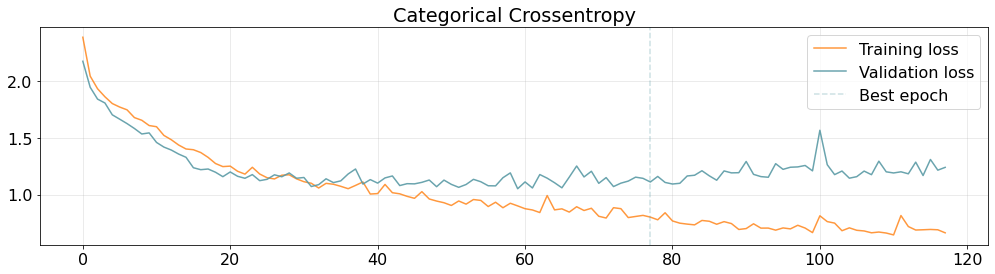

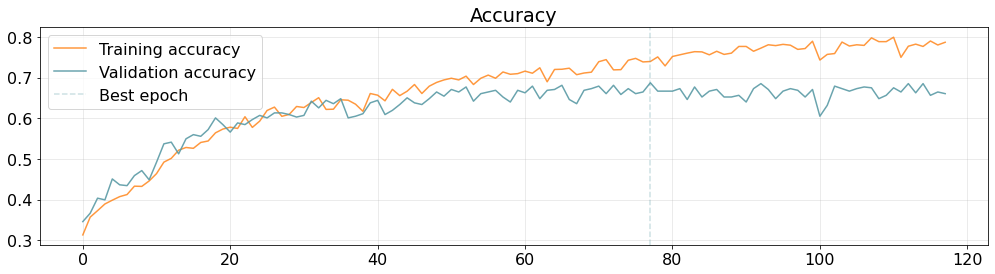

In [ ]:
#Plot the results
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## Salva

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/gdrive/MyDrive/HMW2FINALTRY/resnet_style')


In [ ]:
model_3 = model
model_3.save('/content/resnet_style')

## BILSTM

## Bidirectional LSTM

In [ ]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(64))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(64, activation='relu')(dropout)
    classifier = tfkl.Dropout(.5, seed=seed)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
#build the model and print structure
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_21 (Bidirecti  (None, 36, 512)          538624    
 onal)                                                           
                                                                 
 bidirectional_22 (Bidirecti  (None, 36, 256)          656384    
 onal)                                                           
                                                                 
 bidirectional_23 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                             

In [ ]:
# Train the model: early stopping and mobile learning rate
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=2.5e-4)
    ]
).history

Epoch 1/200
122/122 [==============================] - 12s 41ms/step - loss: 2.1800 - accuracy: 0.2990 - val_loss: 1.9114 - val_accuracy: 0.3580 - lr: 0.0010
Epoch 2/200
122/122 [==============================] - 3s 21ms/step - loss: 2.0006 - accuracy: 0.3495 - val_loss: 1.7977 - val_accuracy: 0.4115 - lr: 0.0010
Epoch 3/200
122/122 [==============================] - 2s 20ms/step - loss: 1.9454 - accuracy: 0.3690 - val_loss: 1.7881 - val_accuracy: 0.4053 - lr: 0.0010
Epoch 4/200
122/122 [==============================] - 2s 20ms/step - loss: 1.8437 - accuracy: 0.3896 - val_loss: 1.7211 - val_accuracy: 0.4074 - lr: 0.0010
Epoch 5/200
122/122 [==============================] - 2s 19ms/step - loss: 1.7455 - accuracy: 0.4303 - val_loss: 1.5745 - val_accuracy: 0.4506 - lr: 0.0010
Epoch 6/200
122/122 [==============================] - 2s 19ms/step - loss: 1.7047 - accuracy: 0.4225 - val_loss: 1.5263 - val_accuracy: 0.4856 - lr: 0.0010
Epoch 7/200
122/122 [==============================] - 2s

In [ ]:
model.save('/content/gdrive/MyDrive/HMW2FINALTRY/bilstm_final')

In [ ]:
model_4= model
model_4.save('/content/bilstm')

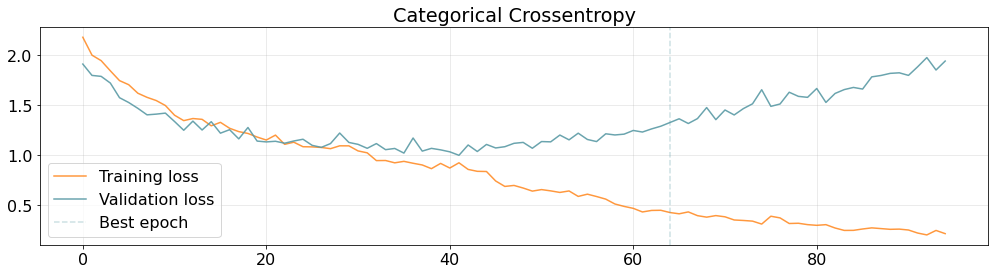

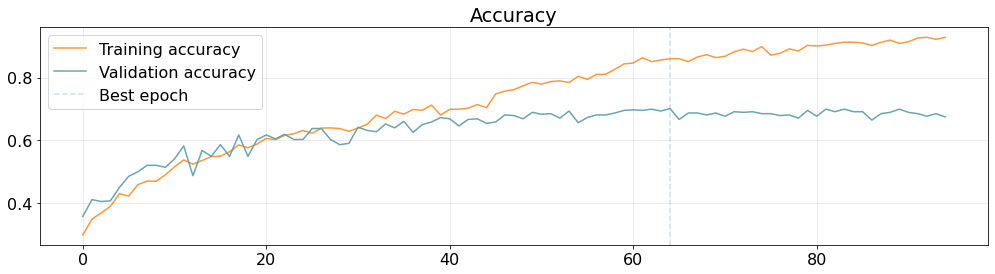

In [ ]:
#To plot the results
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## Final Model class

In [ ]:
class model:
    def __init__(self, path):

        self.model1 = tf.keras.models.load_model('/content/1DCNN')
        self.model2 = tf.keras.models.load_model('/content/1DCLSTM')
        self.model3 = tf.keras.models.load_model('/content/resnet_style')
        self.model4 = tf.keras.models.load_model('/content/bilstm')
        

        #with open(os.path.join(path,'scaler.pickle'), 'rb') as handle:
            
        #    self.scaler = pickle.load(handle)

    def predict(self, X):
        
        
        #np_config.enable_numpy_behavior()
        # Insert your preprocessing here
        X = scaler.transform(X.reshape(-1,X.shape[-1])).reshape(X.shape)

        X1 = X 
        X2 = X 
        X3 = X
        X4 = X
        out1 = self.model1.predict(X1)
        out2 = self.model2.predict(X2)
        out3 = self.model3.predict(X3)
        out4 = self.model4.predict(X4)

        out = tf.add(out1,out2)
        out = tf.add(out,out3)
        out = tf.add(out,out4)
        out = tf.argmax(out, axis=-1)

        return out